# Analítica y Ciencia de Datos

## Jonnathan Cruz y Germán Villar

# Referencias:

Las propiedades y supuestos detrás del Modelo Lineal de Regresión, la pueden encontrar en [Greene, "Econometric Analysis"](http://pages.stern.nyu.edu/~wgreene/Text/econometricanalysis.htm).

También véanse los capítulos 3 y 6 de [ISL](http://www-bcf.usc.edu/~gareth/ISL/getbook.html).

O el capítulo 3 de [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

# Más regularización: Lasso


* Lasso es otro método de regularización de los coeficientes, que utiliza una métrica distinta para penalizar coeficientes grandes.

$$
\beta_{lasso} = argmin_{\beta} (y - X\beta)'(y - X\beta) + \lambda \sum_j \left \vert \beta_j \right \vert
$$

* Desde un punto de vista de optimización, este es un problema de [programación cuadrática](https://en.wikipedia.org/wiki/Quadratic_programming), i.e. uno donde la función objetivo es cuadrática y está sujeto a restricciones lineales.

    * Una alternativa es utilizar una librería de optimización cuadrática como [`cvxopt`](http://cvxopt.org/).
    * Vamos a ver otros métodos para resolver el problema de optimización que son computacionalmente eficientes.


* Así que la mala noticia es que no hay una solución analítica, como si lo había en el caso del Ridge.


* La principal diferencia entre el Lasso y el Ridge es que el segundo reduce los coeficientes, y en el límite, cuando $\lambda \rightarrow \infty$, los coeficientes son cero.


* En Lasso, parte de la solución son algunos coeficientes exactamente iguales a cero, *para cualquier valor de $\lambda$*, así que es un método que permite hacer selección de variables.


# Comparación entre Lasso y Ridge

![caption](figures/lasso_ridge.png)

Figura 6.7 de [ISLR](http://www-bcf.usc.edu/~gareth/ISL/)

# ¿Cómo se encuentra la solución de Lasso?


* Vamos a utilizar un método de optimización que se llama [coordinate descent](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf).


* La idea es simple: queremos minimizar 
$$
f(\beta) = g(\beta) + \sum_i h_i(\beta_i)
$$


donde $g$ es una función convexa y diferenciable, y cada una de las $h_i$ es una función convexa, no necesariamente diferenciable.


* Para encontrar el mínimo podemos hacerlo *coordenada por coordenada*.


* En el caso de Lasso, el siguiente algoritmo funciona perfectamente (ver [acá, por ejemplo](http://web.stanford.edu/~hastie/TALKS/glmnet.pdf)).

# Pseudocódigo de Lasso vía Coordinate Descent


* Estandaricemos la matriz $X$ y $y$.


* Repita lo siguiente hasta que haya convergencia, para todo $k = 1, 2, \cdots, p, 1, 2, \cdots$:

> **Paso 1**: Obtenga los residuos excluyendo el regresor $k$: 
$$    
    r_{-k} = y - x_{-k}\beta_{-k}
$$
>     donde $x_{-k}$ excluye al regresor $k$, y $\beta_{-k}$ es la versión actual de los coeficientes excluyendo al $k-$ésimo.


> **Paso 2**: Obtenga el estimador de OLS simple para el regresor $k$:
    
$$    
    \beta^*_{k} = \frac{1}{N} r_{-k}'x_k = \frac{1}{N} \sum_j r_{-k,j}x_{jk}
$$


> **Paso 3**: Actualice $\beta_k$ por medio de *soft-thresholding*

$$
\begin{eqnarray*}
\beta_k &=& signo(\beta^*_{k})(\left \vert \beta^*_{k} \right \vert -\lambda)_{+} \\
\end{eqnarray*}
$$

>  donde $(x)_{+} = max(0,x)$ denota la [parte positiva](http://mathworld.wolfram.com/PositivePart.html)

# Veamos cómo se hace en Python

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

data_cr = pd.read_excel('Credit (1).xlsx')

nobs    = data_cr.shape[0]
saldo    = np.asarray(data_cr.Balance).reshape((nobs,1))
male     = np.asarray(data_cr.Gender==' Male').reshape((nobs,1))
student  = np.asarray(data_cr.Student=='Yes').reshape((nobs,1))
married  = np.asarray(data_cr.Married=='Yes').reshape((nobs,1))
eth_dum  = np.asarray(pd.get_dummies(data_cr.Ethnicity))[:,:-1]
oth_xmat = data_cr[[u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education']]

labs_x = np.array([u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','Caucasian','Asian'])

prexmat  = np.concatenate((oth_xmat, male, student, married, eth_dum),axis=1)
#print prexmat.shape
nvar = prexmat.shape[1]
# I will start by standardizing/normalizing the matrix
prexmat_std = prexmat.copy()
ind_dum = np.array([pd.Series(prexmat[:,k]).unique().shape[0] for k in range(nvar)])
prexmat_std[:,ind_dum>2] -= prexmat_std[:,ind_dum>2].mean(axis=0).reshape((1,6))
# get the norms
norm_pxmat = np.array([np.linalg.norm(prexmat_std[:,ind_dum>2][:,k]) for k in range(np.sum(ind_dum>2))])
# ready to normalize
prexmat_std[:,ind_dum>2] /= prexmat_std[:,ind_dum>2].std(axis=0).reshape((1,6))


# also standardize y
#yy_std = saldo.copy()
#yy_std -= yy_std.mean()
#yy_std /= yy_std.std()

In [12]:
# Fijemos un lambda:
lambda_vec = 0.1
# Inicialicemos el vector:
beta_actual = np.zeros((1,11))
dist = 1
counter = 0
maxiter = 10000
# loop externo: si no hay convergencia continúe
while dist>0.001: 
    #or counter<maxiter:
    # Loop interno: ciclo con los regresores
    beta_old = beta_actual.copy()
    for k in range(11):
        # Residuos parciales excluyendo k
        inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
        xmat_k   = prexmat_std[:,inc_k]
        beta_k   = beta_actual[0,inc_k]
        resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
        # OLS simple de k:
        beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
        # Actualicemos beta_k
        beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
    # Actualicemos distancia:
    dist = np.max(np.abs(beta_actual-beta_old))
    counter +=1
print "total iteraciones: ", counter
pd.DataFrame(beta_actual.T, index= labs_x.flatten(), columns = ['Nuestro'])

total iteraciones:  1502


,Nuestro
Income,-277.946835
Limit,457.085481
Rating,156.364030
Cards,21.152556
Age,-4.024591
Education,-3.706099
Hombre,159.345633
Estudiante,67.721863
Casado,239.613284
Caucasian,74.192538


In [61]:
# Fijemos un lambda:
lambda_vec = 0.1
# Inicialicemos el vector:
beta_actual = np.zeros((1,11))
dist = 1
counter = 0
maxiter = 10000
# loop externo: si no hay convergencia continúe
while dist>0.001: 
    #or counter<maxiter:
    # Loop interno: ciclo con los regresores
    beta_old = beta_actual.copy()
    for k in range(11):
        # Residuos parciales excluyendo k
        inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
        xmat_k   = prexmat_std[:,inc_k]
        beta_k   = beta_actual[0,inc_k]
        resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
        # OLS simple de k:
        beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
        # Actualicemos beta_k
        beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
    # Actualicemos distancia:
    dist = np.max(np.abs(beta_actual-beta_old))
    counter +=1
print "total iteraciones: ", counter
pd.DataFrame(beta_actual.T, index= labs_x.flatten(), columns = ['Nuestro'])

total iteraciones:  1502


,Nuestro
Income,-277.946835
Limit,457.085481
Rating,156.364030
Cards,21.152556
Age,-4.024591
Education,-3.706099
Hombre,159.345633
Estudiante,67.721863
Casado,239.613284
Caucasian,74.192538


# Cómo se haría en Scikit-learn?

In [62]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1.0, copy_X = True,fit_intercept=True, max_iter=1000000,
   normalize=True, positive=False, precompute=False, random_state=12345678,
   selection='random', tol=0.0001, warm_start=False)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Lasso'])

,Lasso
Income,-181.863025
Limit,225.546691
Rating,295.790027
Cards,1.056022
Age,-0.000000
Education,-0.000000
Hombre,0.000000
Estudiante,348.297960
Casado,-0.000000
Caucasian,-0.000000


In [63]:
# importemos el método
from sklearn.linear_model import Ridge
# llamemos el método, con alpha = 1.0
clf = Ridge(alpha=.5, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, solver='auto')
# Ajustemos el modelo
clf.fit(prexmat, yy_std)
# imprimamos los coeficientes estimados
coef_scikit = pd.DataFrame(clf.coef_.T, index= labs_x, columns=['Scikit_Learn'])
print coef_scikit

            Scikit_Learn
Income         -1.059305
Limit           0.074367
Rating          1.105899
Cards          15.093542
Age            -1.015346
Education       0.017617
Hombre         -3.286943
Estudiante    267.862696
Casado        -11.147953
Caucasian      -6.746213
Asian           0.867821


In [64]:
from sklearn import linear_model
clf = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5 , copy_X = True,fit_intercept=True, max_iter=1000000,
   normalize=True, positive=False, precompute=False, random_state=12345678,
   selection='cyclic', tol=0.0001, warm_start=False)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Elastic Net'])


,Elastic Net
Income,0.994403
Limit,1.905411
Rating,1.909799
Cards,0.147316
Age,0.000000
Education,-0.000000
Hombre,-0.000000
Estudiante,1.806573
Casado,-0.000000
Caucasian,0.000000


Tenemos muy pocas variables como para apreciar el efecto de Elastic Net al incluir grupos. 

# Caso $p>>n$: Diabetes

Ahora veamos cómo diferen los paths de Lasso y Elastic Net.

Automatically created module for IPython interactive environment
Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positve elastic net...


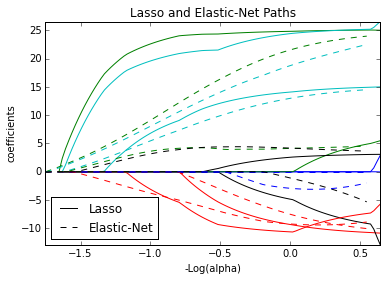

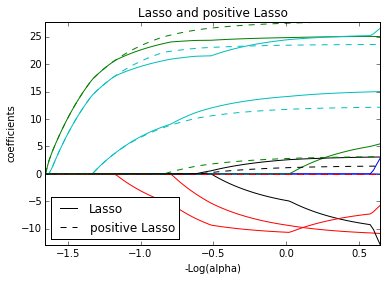

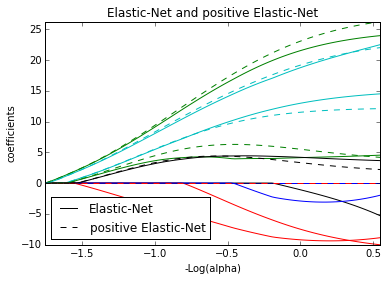

In [82]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positve elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()
ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
ax = plt.gca()
ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
l1 = plt.plot(-np.log10(alphas_lasso), coefs_lasso.T)
l2 = plt.plot(-np.log10(alphas_positive_lasso), coefs_positive_lasso.T,
              linestyle='--')

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
ax = plt.gca()
ax.set_color_cycle(2 * ['b', 'r', 'g', 'c', 'k'])
l1 = plt.plot(-np.log10(alphas_enet), coefs_enet.T)
l2 = plt.plot(-np.log10(alphas_positive_enet), coefs_positive_enet.T,
              linestyle='--')

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [ ]:
# Miremos todo el path de lasso
L = 100
lambda_grid = np.linspace(0,0.6,L)
BetaLasso  = np.zeros((L,11))
for lamb in range(L):
    lambda_vec = lambda_grid[lamb]
    # Inicialicemos el vector:
    beta_actual = np.zeros((1,11))
    dist = 1
    counter = 0
    maxiter = 10000
    # loop externo: si no hay convergencia continúe
    while dist>0.001: 
        #or counter<maxiter:
        # Loop interno: ciclo con los regresores
        beta_old = beta_actual.copy()
        for k in range(11):
            # Residuos parciales excluyendo k
            inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
            xmat_k   = prexmat_std[:,inc_k]
            beta_k   = beta_actual[0,inc_k]
            resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
            # OLS simple de k:
            beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
            # Actualicemos beta_k
            beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
        # Actualicemos distancia:
        dist = np.max(np.abs(beta_actual-beta_old))
        counter +=1
    # terminó, podemos actualizar
    BetaLasso[lamb,:] = beta_actual.reshape((1,11))